# BEIJING POLLUTION FORESCASTING

The dataset for multivariant time series was found in https://www.kaggle.com/datasets/djhavera/beijing-pm25-data-data-set/data


In [59]:
import pandas as pd

# Load the dataset
pollution_df = pd.read_csv('../data/pollution_beijing.csv')

# Display the first few rows of the dataset
print(pollution_df.head(10))

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0
5   6  2010      1    1     5    NaN   -19 -10.0  1017.0   NW  16.10   0   0
6   7  2010      1    1     6    NaN   -19  -9.0  1017.0   NW  19.23   0   0
7   8  2010      1    1     7    NaN   -19  -9.0  1017.0   NW  21.02   0   0
8   9  2010      1    1     8    NaN   -19  -9.0  1017.0   NW  24.15   0   0
9  10  2010      1    1     9    NaN   -20  -8.0  1017.0   NW  27.28   0   0


**Date:**

Description: The date and time of the measurement.

**PM2.5:**

Description: The concentration of particulate matter with a diameter of less than 2.5 micrometers in the air (measured in micrograms per cubic meter). This is a critical measure of air pollution.


**DEWP (Dew Point):**

Description: The temperature at which air becomes saturated with moisture and dew can form (measured in degrees Celsius).


**TEMP (Temperature):**

Description: The ambient temperature (measured in degrees Celsius).


**PRES (Pressure):**

Description: The atmospheric pressure (measured in hPa).


**cbwd (Combined Wind Direction):**

Description: The direction of the wind combined into categories such as NE (northeast), NW (northwest), SE (southeast), and SW (southwest).


**Iws (Cumulated Wind Speed):**

Description: The cumulative wind speed over the hour (measured in m/s).


**Is (Cumulated Hours of Snow):**

Description: The cumulative number of hours of snow observed in the previous 24 hours (measured in hours).


**Ir (Cumulated Hours of Rain):**

Description: The cumulative number of hours of rain observed in the previous 24 hours (measured in hours).


## Initial analysis and preprocessing

Some initial preprocessing to encoded the varible and get better data

In [60]:
from sklearn.preprocessing import LabelEncoder


# Convert the 'date' column to datetime format
pollution_df['date'] = pd.to_datetime(pollution_df[['year', 'month', 'day', 'hour']])
# Drop the 'year', 'month', 'day', and 'hour' columns
pollution_df = pollution_df.drop(columns=['year', 'month', 'day', 'hour'])

# Set 'date' as the index
pollution_df.set_index('date', inplace=True)

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Apply the label encoder to the 'cbwd' column
pollution_df['cbwd'] = label_encoder.fit_transform(pollution_df['cbwd'])


We have combined the date into a single column named 'date' and removed the 'years','month','day','hour' column

In [61]:
# Check the columns and data types
print(pollution_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   pm2.5   41757 non-null  float64
 2   DEWP    43824 non-null  int64  
 3   TEMP    43824 non-null  float64
 4   PRES    43824 non-null  float64
 5   cbwd    43824 non-null  int32  
 6   Iws     43824 non-null  float64
 7   Is      43824 non-null  int64  
 8   Ir      43824 non-null  int64  
dtypes: float64(4), int32(1), int64(4)
memory usage: 3.2 MB
None


We can obseve that there 438244 entries with a total of 13 columns, and the type are in64 or float. Also we can see that in the pm2.5 it has 41.757 non-null entries, meaning there are 2067 missing values

In [62]:
# Extract the year from the 'date' column
years = pollution_df.index.year

# Find the unique years in the dataset
unique_years = years.unique()

# Count the number of unique years
number_of_years = len(unique_years)

# Print the results
print(f"Unique years in the dataset: {unique_years}")
print(f"Total number of years in the dataset: {number_of_years}")

Unique years in the dataset: Index([2010, 2011, 2012, 2013, 2014], dtype='int32', name='date')
Total number of years in the dataset: 5


Missing values in 'pm2.5': 2067 out of 43824 (4.72%)


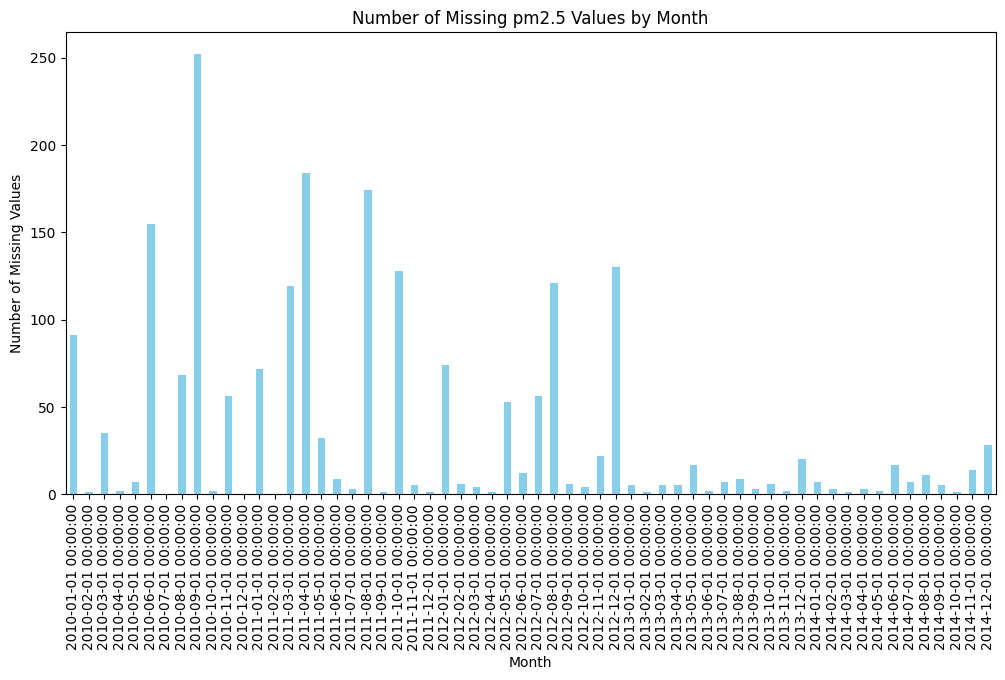

In [63]:
import matplotlib.pyplot as plt

# Check the number of missing values in pm2.5
missing_pm25 = pollution_df['pm2.5'].isnull().sum()
total_entries = len(pollution_df)
print(f"Missing values in 'pm2.5': {missing_pm25} out of {total_entries} ({missing_pm25/total_entries*100:.2f}%)")

# Visualize the distribution of missing values over time
plt.figure(figsize=(12, 6))
pollution_df['pm2.5'].isnull().resample('MS').sum().plot(kind='bar', color='skyblue')
plt.title('Number of Missing pm2.5 Values by Month')
plt.xlabel('Month')
plt.ylabel('Number of Missing Values')
plt.show()

the plot suggests that while the dataset is mostly complete, there are several periods, especially in the early years, we have more missing data. As we have not that much missing data, we are going to impute with ffill (using the last observed value to fill the missing ones), and bfill for the start.

In [64]:
# Forward fill
pollution_df['pm2.5'] = pollution_df['pm2.5'].ffill()

# Apply backward fill to handle any remaining NaNs (especially at the start)
pollution_df['pm2.5'] = pollution_df['pm2.5'].bfill()

remaining_missing = pollution_df['pm2.5'].isnull().sum()
print(f"Remaining missing values in 'pm2.5': {remaining_missing}")

Remaining missing values in 'pm2.5': 0


## Exploratory Data Analysis (EDA)

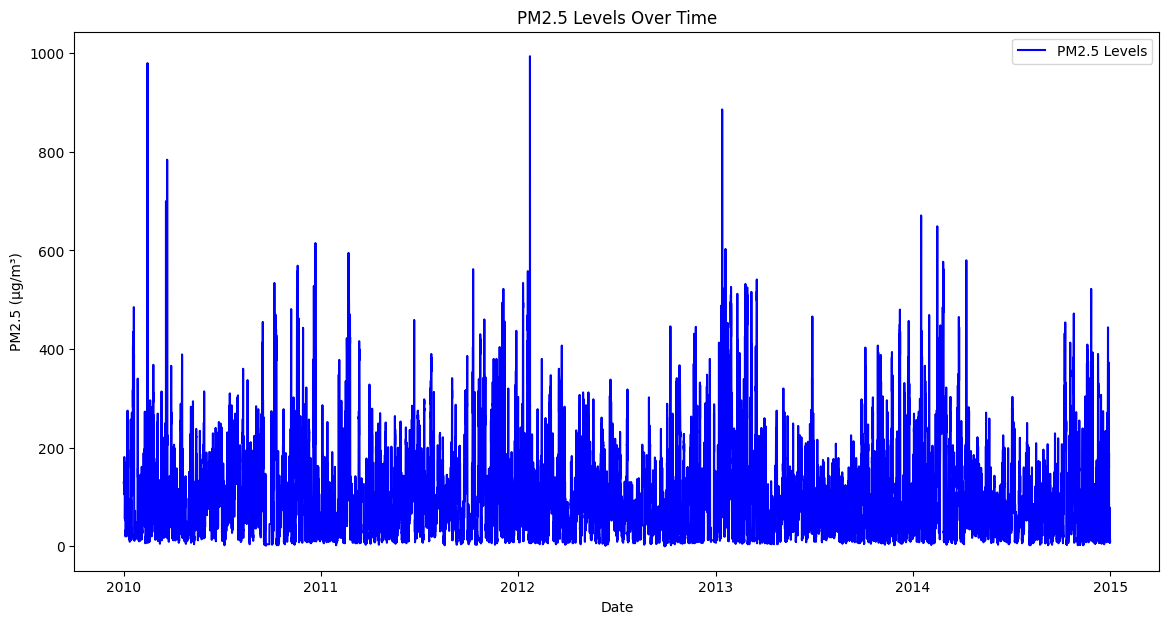

In [65]:
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(14, 7))
plt.plot(pollution_df.index, pollution_df['pm2.5'], label='PM2.5 Levels', color='blue')
plt.title('PM2.5 Levels Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 (μg/m³)')
plt.legend()
plt.show()




The PM2.5 levels fluctuate widely, but there isn't a clear visual indication of consistent seasonal patterns or cycles in this raw data.

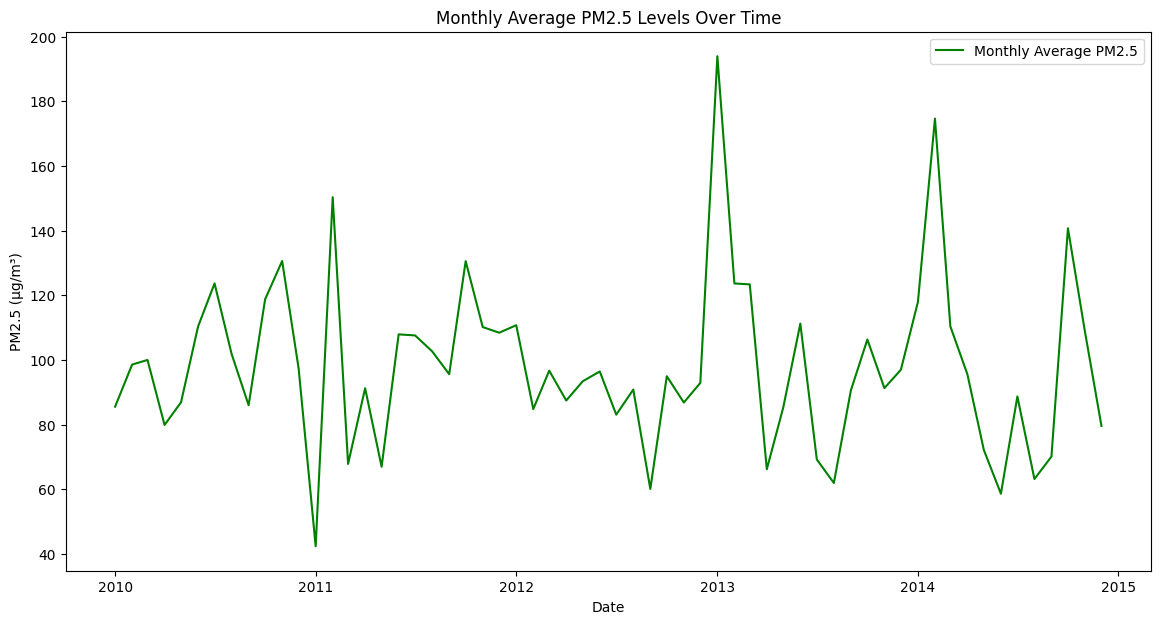

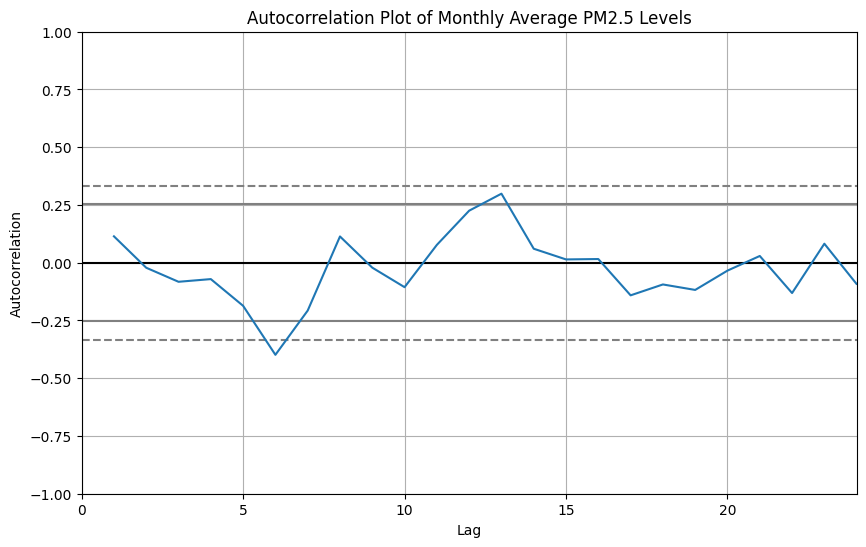

In [66]:
monthly_avg = pollution_df['pm2.5'].resample('MS').mean()

plt.figure(figsize=(14, 7))
plt.plot(monthly_avg, label='Monthly Average PM2.5', color='green')
plt.title('Monthly Average PM2.5 Levels Over Time')
plt.xlabel('Date')
plt.ylabel('PM2.5 (μg/m³)')
plt.legend()
plt.show()

# Plot the autocorrelation with a shorter lag
plt.figure(figsize=(10, 6))
autocorrelation_plot(monthly_avg)
plt.xlim([0, 24])
plt.title('Autocorrelation Plot of Monthly Average PM2.5 Levels')
plt.show()

The monthly averages do show some fluctuations, but the patterns are not strongly repetitive from year to year. The weak peaks in the autocorrelation plot suggest that if there is seasonality, it is not very strong or consistent. And the peaks in autocorrelation are not consistent enough to definitively suggest a strong annual seasonality. The correlation diminishes and fluctuates, indicating that any seasonality present is weak or irregular.

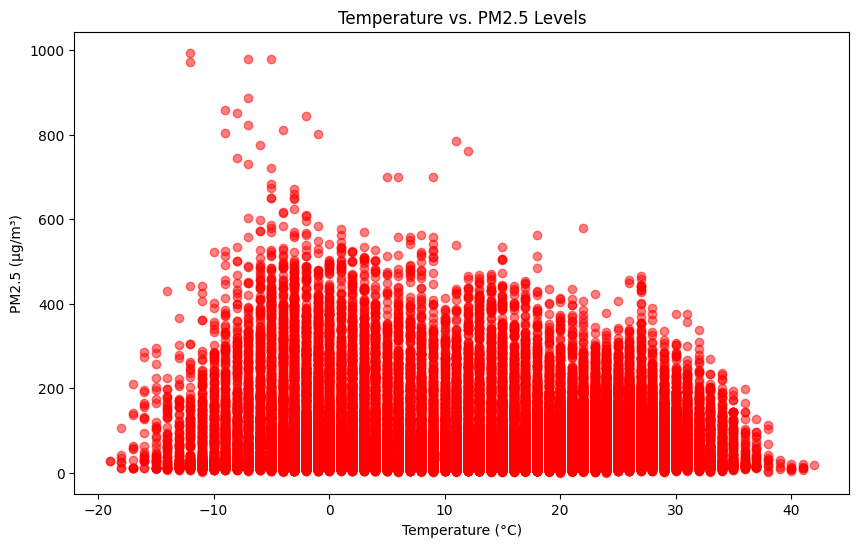

In [68]:
plt.figure(figsize=(10, 6))
plt.scatter(pollution_df['TEMP'], pollution_df['pm2.5'], alpha=0.5, color='red')
plt.title('Temperature vs. PM2.5 Levels')
plt.xlabel('Temperature (°C)')
plt.ylabel('PM2.5 (μg/m³)')
plt.show()

PM2.5 levels tend to be higher at lower temperatures (below 0°C) and decrease as temperatures rise above 0°C. There is a noticeable concentration of higher PM2.5 values when temperatures are low, indicating that colder weather may correlate with increased air pollution levels. However, as the temperature increases, PM2.5 levels generally decrease, with fewer high pollution events occurring in warmer conditions.

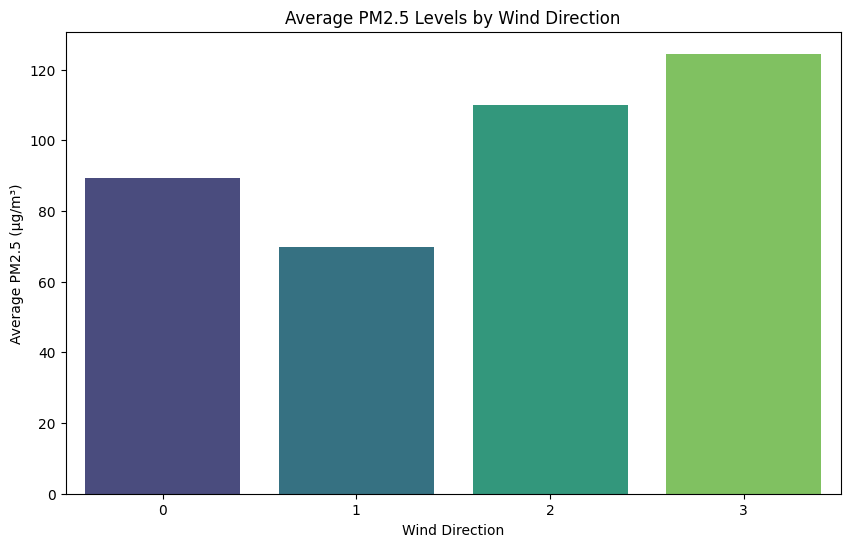

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average PM2.5 level for each wind direction
avg_pm25_by_cbwd = pollution_df.groupby('cbwd')['pm2.5'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='cbwd', y='pm2.5', data=avg_pm25_by_cbwd, palette='viridis')
plt.title('Average PM2.5 Levels by Wind Direction')
plt.xlabel('Wind Direction')
plt.ylabel('Average PM2.5 (μg/m³)')
plt.show()


The wind direction labeled as 3 (which corresponds to SW in the original labels) appears to be associated with the highest average PM2.5 levels, indicating that this direction might bring in more polluted air. Conversely, the direction labeled as 1 (NW) has the lowest average PM2.5 levels, suggesting it is associated with cleaner air.

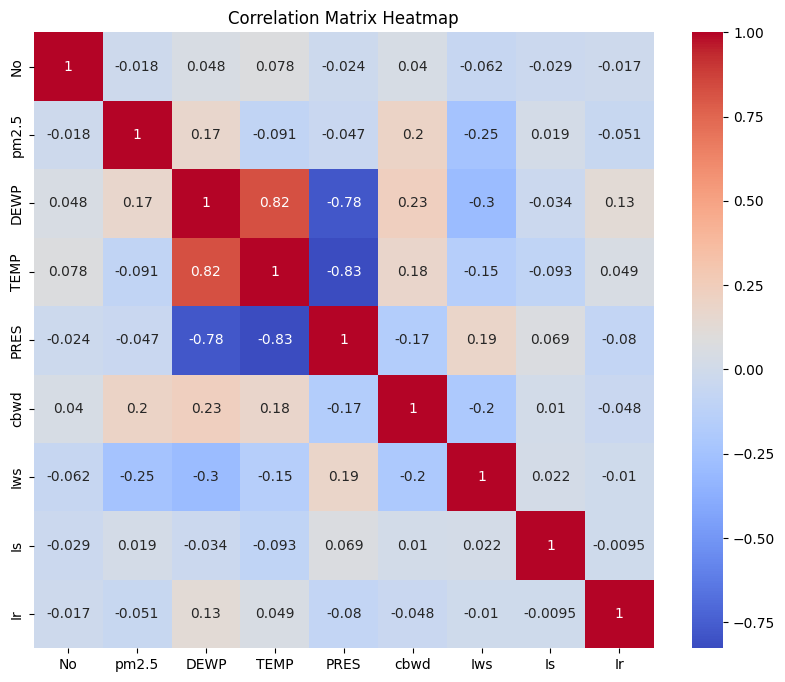

In [40]:
import seaborn as sns

plt.figure(figsize=(10, 8))
correlation_matrix = pollution_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

Given the strong correlations observed among some of the variables in our dataset, I recommend simplifying the model by addressing potential multicollinearity. Specifically, I suggest using Principal Component Analysis (PCA) to reduce the dimensionality of the dataset by transforming the correlated variables into a smaller set of uncorrelated components. This will help us retain most of the variance while removing redundant information.

To evaluate the effectiveness of this approach, I will build and compare two models: one using the original set of variables and another using the PCA-transformed variables. By comparing the performance of these models, we can determine whether PCA helps improve the model's accuracy and interpretability. This approach will allow us to see if reducing the dataset's dimensionality enhances the model's performance without losing valuable information.

## Models

### Prepare the Data

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Drop unnecessary columns and define features and target
X = pollution_df.drop(columns=['pm2.5'])
y = pollution_df['pm2.5']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (we'll reserve a part for prediction)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Prepare data for PCA model
X_train_pca, X_test_pca = X_train, X_test  # Will be transformed after fitting PCA

# Fit PCA with enough components to explain ~95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### Build the Models

In this analysis, I am using the **VAR (Vector AutoRegressive)** algorithm to forecast future PM2.5 levels. VAR models are particularly well-suited for this task because they are designed to predict future values of a time series based on its own past values. This makes them ideal for scenarios where future values of other variables (regressors) are not available, which aligns with our project's requirement to predict 100 future time steps without access to future regressor data.
I will use the last 50 time steps to inform our model and predict the next 100 time steps. The choice of 50 time steps as input allows the model to capture sufficient historical information and patterns, enhancing its ability to make accurate future predictions. By leveraging the past 50 observations, the model can better understand the temporal dependencies and trends, which is crucial for making reliable predictions over a longer horizon.


#### Original Data

In [77]:
from statsmodels.tsa.vector_ar.var_model import VAR
import pandas as pd

# Combine X_train and y_train to create a multivariate dataset
data_original = pd.DataFrame(X_train, columns=pollution_df.columns.drop('pm2.5'))
data_original['PM2.5'] = y_train.values

# Train a VAR model with the original data
model_original = VAR(data_original)
model_fitted_original = model_original.fit(maxlags=50)  # Adjust the lags based on your data

# Predict the next 100 time steps
forecast_input_original = data_original.values[-50:]  # Using the last 5 known time steps
forecasted_values_original = model_fitted_original.forecast(forecast_input_original, steps=100)

# Convert the results into a DataFrame for better analysis
forecasted_df_original = pd.DataFrame(forecasted_values_original, columns=data_original.columns)
print(forecasted_df_original[['PM2.5']])  # Display only the PM2.5 predictions

        PM2.5
0   19.416792
1   22.436445
2   30.498204
3   31.374023
4   36.861064
..        ...
95  83.297162
96  87.249341
97  91.028450
98  94.257588
99  96.667739

[100 rows x 1 columns]


#### PCA-Transformed Data

In [79]:
# Using the principal components from PCA
data_pca = pd.DataFrame(X_train_pca)
data_pca['PM2.5'] = y_train.values

# Train a VAR model with the PCA-transformed data
model_pca = VAR(data_pca)
model_fitted_pca = model_pca.fit(maxlags=50)  # Adjust the lags based on your data

# Predict the next 100 time steps
forecast_input_pca = data_pca.values[-50:]  # Using the last 5 known time steps
forecasted_values_pca = model_fitted_pca.forecast(forecast_input_pca, steps=100)

# Convert the results into a DataFrame for better analysis
forecasted_df_pca = pd.DataFrame(forecasted_values_pca, columns=data_pca.columns)
print(forecasted_df_pca[['PM2.5']])  # Display all predictions

         PM2.5
0    19.415672
1    22.507969
2    29.088711
3    29.533489
4    35.392843
..         ...
95   94.699426
96   98.338689
97  101.413726
98  103.755915
99  105.261652

[100 rows x 1 columns]


#### Visualization of the predictions

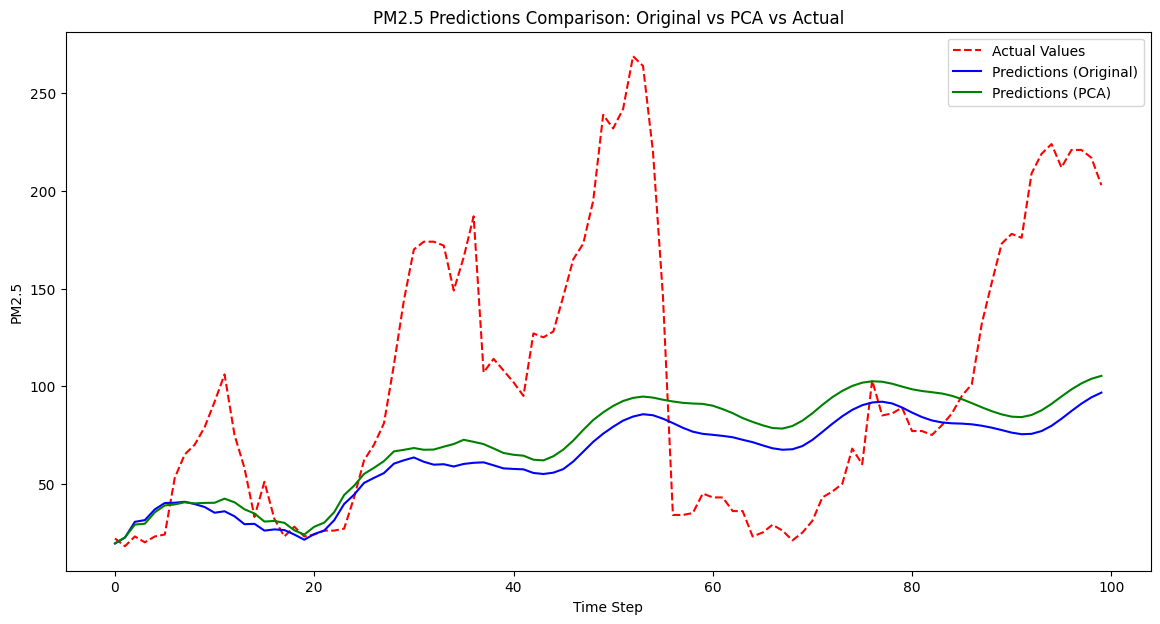

In [80]:
import matplotlib.pyplot as plt

# Assuming 'y_test' contains the actual PM2.5 values for comparison
actual_values = y_test.values[:100]  # The first 100 values from the test set

# Compare PM2.5 predictions for both models with actual values
plt.figure(figsize=(14, 7))
plt.plot(actual_values, label='Actual Values', color='red', linestyle='dashed')
plt.plot(forecasted_df_original['PM2.5'], label='Predictions (Original)', color='blue')
plt.plot(forecasted_df_pca[forecasted_df_pca.columns[-1]], label='Predictions (PCA)', color='green')
plt.title('PM2.5 Predictions Comparison: Original vs PCA vs Actual')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

The plot compares the actual PM2.5 values (red dashed line) with predictions from models using original data (blue line) and PCA-transformed data (green line) over 100 time steps. Both models smooth the predictions and fail to capture the sharp peaks and drops in the actual data, indicating that they might be underfitting or not fully capturing the complexity of the time series. The PCA model performs slightly better in some areas, but overall, both models struggle to accurately predict the more volatile aspects of PM2.5 levels.

#### Evaluation

In [81]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Assuming 'y_test' contains the actual PM2.5 values for comparison

# For the model using original data
predicted_original = forecasted_df_original['PM2.5'].values
actual_original = y_test.values[:100]  # The first 100 values from the test set

# Calculate RMSE, MSE, and MAE for the original model
rmse_original = np.sqrt(mean_squared_error(actual_original, predicted_original))
mse_original = mean_squared_error(actual_original, predicted_original)
mae_original = mean_absolute_error(actual_original, predicted_original)

print(f"Original VAR Model - RMSE: {rmse_original}, MSE: {mse_original}, MAE: {mae_original}")

# For the model using PCA-transformed data
predicted_pca = forecasted_df_pca[forecasted_df_pca.columns[-1]].values
actual_pca = y_test.values[:100]  # The first 100 values from the test set

# Calculate RMSE, MSE, and MAE for the PCA model
rmse_pca = np.sqrt(mean_squared_error(actual_pca, predicted_pca))
mse_pca = mean_squared_error(actual_pca, predicted_pca)
mae_pca = mean_absolute_error(actual_pca, predicted_pca)

print(f"PCA VAR Model - RMSE: {rmse_pca}, MSE: {mse_pca}, MAE: {mae_pca}")

Original VAR Model - RMSE: 74.24483055118594, MSE: 5512.294863574314, MAE: 55.99101966261864
PCA VAR Model - RMSE: 70.33361672691795, MSE: 4946.817641888993, MAE: 54.92866325011334


The PCA-transformed model slightly outperforms the original, suggesting that PCA effectively captured critical information while reducing noise. However, both models struggle with accuracy, especially in predicting sharp changes in PM2.5 levels. The smoothed predictions indicate underfitting or a lack of capturing complex patterns, so next steps should include fine-tuning the models or exploring more advanced time series models to improve prediction accuracy.